In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, mutual_info_classif
from sklearn.metrics import *
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.utils import resample # permet de faire du rééchantillonage
import warnings
import math

In [2]:
train_dataset = pd.read_csv("sets/train.csv") 
df = train_dataset.copy()
test_dataset = pd.read_csv("sets/test.csv") 
test_df = test_dataset.copy()

pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")

print(df.columns)
print(test_df.columns)

continuous_features = ['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
categorial_features = df.drop(continuous_features, axis=1).columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

# **Preprocessing & Modelisation**
## **1. Data Preprocessing**
- ### Feature Engineering : 

In [3]:
def feature_engineering(df):
    #df["Soil_Types"] = df[[col for col in categorial_features if 'Soil' in col]].idxmax(axis=1)
    #df["Wilderness_Area"] = df[[col for col in categorial_features if 'Wilderness' in col]].idxmax(axis=1)

    df["Hypothenuse_Distance_To_Hydrology"] = np.sqrt(df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)
    #df["Distance_To_Hydrology"] = np.sqrt(df["Elevation"]**2 + df["Horizontal_Distance_To_Hydrology"]**2)
    df["Hypothenuse_Distance_To_Roadways"] = np.sqrt(df["Elevation"]**2 + df["Horizontal_Distance_To_Roadways"]**2)
    #df["Hypothenuse_Distance_To_Roadways-Hydrology"] = np.sqrt(df["Vertical_Distance_To_Hydrology"]**2 + df["Horizontal_Distance_To_Roadways"]**2)
    df["Hypothenuse_Distance_To_Fire_Points"] = np.sqrt(df["Elevation"]**2 + df["Horizontal_Distance_To_Fire_Points"]**2)
    df["Hypothenuse_Distance_To_Fire_Points-Hydrology"] = np.sqrt(df["Vertical_Distance_To_Hydrology"]**2 + df["Horizontal_Distance_To_Fire_Points"]**2)
    df["Distance_To_Roadways-Fire_Points"] = np.abs(df["Horizontal_Distance_To_Roadways"] - df["Horizontal_Distance_To_Fire_Points"])
    df["Distance_To_Roadways-Hydrology"] = np.abs(df["Horizontal_Distance_To_Roadways"] - df["Horizontal_Distance_To_Hydrology"])
    #df["Distance_To_Fire_Points-Hydrology"] = np.abs(df["Horizontal_Distance_To_Fire_Points"] - df["Horizontal_Distance_To_Hydrology"])
    df["Difference_Elevation-Hydrology"] = np.abs(df["Elevation"] - df["Vertical_Distance_To_Hydrology"])
    #df["Northness"] = np.cos(np.radians(df["Aspect"]))
    #df["Eastness"] = np.sin(np.radians(df["Aspect"]))
    #df["Roughness"] = np.sqrt(df["Slope"]**2 + np.cos(np.radians(df["Aspect"]))**2 + np.sin(np.radians(df["Aspect"]))**2)


    return df

- ### Encodage : 

In [4]:
def encodage(df):
    #df[continuous_features] = StandardScaler().fit_transform(df[continuous_features])
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype("category").cat.codes
    df = df.astype({col : "int16" for col in df.columns})

    return df

- ### Selection des variables : 

In [5]:
def features_selection(df):
    return df

- ### Imputation : 
    - la suppression de 'Hillshade_9am' et 'Hillshade_3pm' semble étonnement augmenter les performances du modèles
    - idem pour Slope

In [191]:
def imputation(df):
    #df = df.drop([col for col in categorial_features if "Soil_Type" in col], axis=1)
    #df = df.drop(["Id", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Elevation", "Wilderness_Area1", "Soil_Type7", "Soil_Type15", "Hillshade_9am", "Hillshade_3pm", 
     #             "Soil_Type1", "Soil_Type4", "Soil_Type29"], axis=1)
    
    scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
    #outliers = scaled_df[scaled_df["Vertical_Distance_To_Hydrology"] > 0.9]
    #df = df.drop(outliers.index)

    return df

- ### Transformation : 
    - Aspect : cbrt : 109
    - Slope : sqrt : 18
    - Horizontal_Distance_To_Hydrology : sqrt : 42
    - Vertical_Distance_To_Hydrology : cbrt : 223
    - Horizontal_Distance_To_Roadways : cbrt : 22
    - Horizontal_Distance_To_Fire_Points : cbrt : 9

In [192]:
print(continuous_features)
def transformation(df):
    print("transformation")
    for col in ["Aspect", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]:
        if col in df.columns:
            df[col] = np.cbrt(df[col])
    for col in ["Vertical_Distance_To_Hydrology"]:
        if col in df.columns:
            df[col] = np.sqrt(df[col])

    """
    col = "Horizontal_Distance_To_Fire_Points"
    df[col] = np.cbrt(df[col])

    anderson = stats.anderson(df[col], dist="norm")
    print(f"{col} : ", anderson.statistic)"""

    return df

['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- ### Train-Test split : 

In [193]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

- ### Preprocessing : 

In [194]:
def preprocessing(df):
    df = feature_engineering(df)
    df = encodage(df)
    df = features_selection(df)
    df = imputation(df)
    df = transformation(df)

    X = df.drop("Cover_Type", axis=1)
    y = df["Cover_Type"]
    y -= 1

    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

transformation
transformation


- ### Transformation Inversion : 

In [195]:
def transformation_inversion(y_test, y_pred):
    return y_test, y_pred

## **2. Modelisation**
- ### Model : 

In [205]:
model = make_pipeline(RandomForestClassifier(random_state=0, n_estimators=390, criterion="entropy", max_depth=None, min_weight_fraction_leaf=0, max_features="log2", max_leaf_nodes=None, min_impurity_decrease=0,
                               bootstrap=False, oob_score=False, n_jobs=-1, warm_start=False, class_weight="balanced_subsample", ccp_alpha=0, max_samples=None))
"""
model = XGBClassifier(
    objective='multi:softmax',
    booster='gbtree',
    tree_method='auto',
    grow_policy='depthwise',
    max_depth=10,
    learning_rate=0.4,
    n_estimators=100,
    silent=True,
    n_jobs=-1,
    gamma=0,
    min_child_weight=0, # overfitting
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    importance_type='weight',
    enable_categorical=False,
    interaction_constraints=None,
    max_bin=256,
    monotone_constraints=None,
    num_parallel_tree=1,
    predictor='auto',
    n_gpus=0,
    validate_parameters=1,
    use_label_encoder=True,
    grow_policy_depthwise=False
)"""
model = LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.15, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight='balanced', 
                       min_split_gain=2.5, min_child_weight=0.001, min_child_samples=20, subsample=1, subsample_freq=0, colsample_bytree=1, reg_alpha=0.0, reg_lambda=0.0, random_state=0, 
                       n_jobs=-1, importance_type='split', verbosity=-1)

"""
Overfitting : 
max_depth, min_weight_fraction_leaf, max_leaf_nodes, min_impurity_decrease, min_split_gain
"""

'\nOverfitting : \nmax_depth, min_weight_fraction_leaf, max_leaf_nodes, min_impurity_decrease, min_split_gain\n'

- ### Metric : 

- ### Evaluation : Accuracy
    - RandomForestClasssifier :
        - 1.000 et 0.8896
        - 0.9559 et 0.8413
    - XGBoostClassifier :
        - 1.000 et 0.8806
    - LGBMClassifier : 
        - 1.000 et 0.8826
        - 0.9187 et 0.8347
        - 0.9396 et 0.8466 : aucune suppression de variable

Train score : 0.9396
Test score : 0.8466


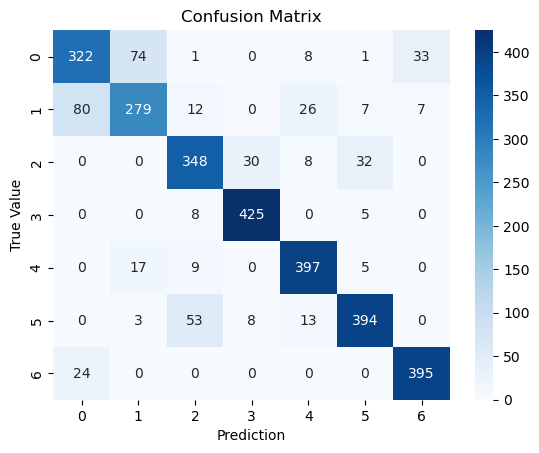

In [203]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    y_test_inv, y_pred_inv = transformation_inversion(y_test, y_pred)

    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test_inv, y_pred_inv)
    print(f"Train score : {train_score:.4f}")
    print(f"Test score : {test_score:.4f}")
    """
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), random_state=0)

    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label="Train Score")
    plt.plot(N, val_score.mean(axis=1), label="Validation Score")
    plt.title(f"Accuracy Score : {accuracy_score(y_test_inv, y_pred_inv):.4f}")
    plt.legend()"""

    plt.figure()
    cm = confusion_matrix(y_test_inv, y_pred_inv)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prediction")
    plt.ylabel("True Value")
    plt.title("Confusion Matrix")

evaluation(model)